## Eli EEG gel data

Example notebook to test the data that Eli sent me on 2024-09-27 regarding his EEG gel collaboration with the group in Edmonton.

## Import libraries

In [54]:
# Common packages
import numpy as np
import matplotlib.pyplot as plt
import pyxdf
import mne
import sys
import seaborn as sns

## Local packages
sys.path.append('..')
from Functions import import_data
from Functions.eeg_quality_index import EEGQualityIndex

## Magic commands
# - Interactive plots
%matplotlib qt

# - Autoreload packages
%load_ext autoreload
%autoreload 3

Channels marked as bad: none
Channels marked as bad: none
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Eyes open

Import data file and visualize EEG data.

Creating RawArray with float64 data, n_channels=16, n_times=38800
    Range : 0 ... 38799 =      0.000 ...   151.559 secs
Ready.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 sec)



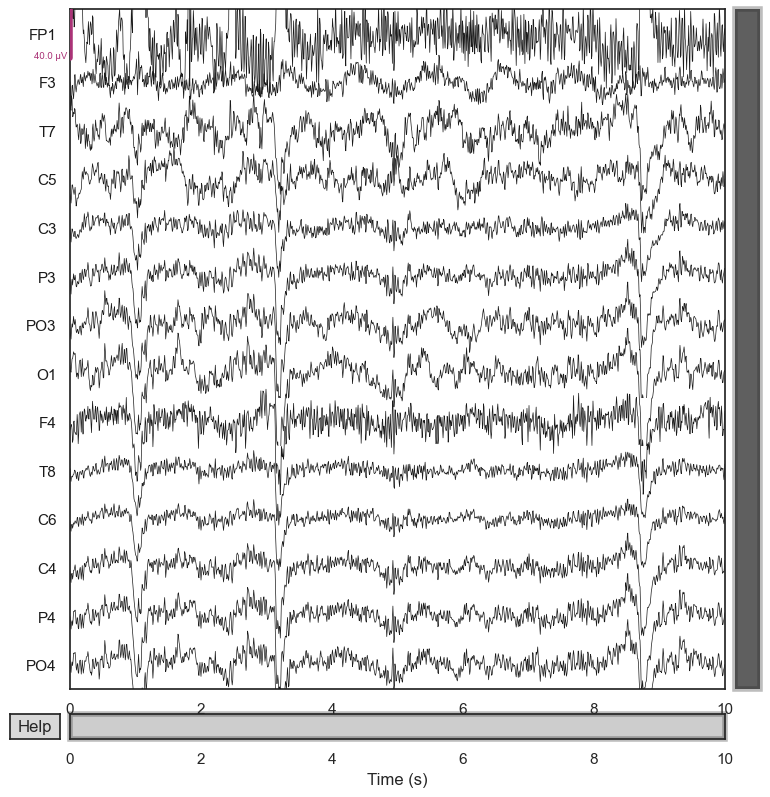

In [55]:
eeg_file = r'..\\Data\\Data_Edmonton_Gels_Sept2024\\sub-P001\\ses-S001\\eeg\\sub-P001_ses-S001_task-eyes_open_release_run-001_eeg.xdf'
mne_data = import_data.xdf_to_mne(eeg_file)

#Rereference to FP2
mne_data.set_eeg_reference(ref_channels=['FP2'])

#Drop the first 10 seconds and last 10 seconds of data
mne_data.crop(tmin=10, tmax=mne_data.times[-10])

#Remove FP2 and O2 channels
mne_data.drop_channels(['FP2', 'O2'])

#Make a copy of the data for cleaning, another for raw
mne_data_raw = mne_data.copy()
mne_data_clean = mne_data.copy()
#Clean the data with simple bandpass filtering
mne_data_clean.filter(1, 40)

mne_data_clean.plot()

#Make the clean epoch
#This clean epoch is only for eyes_open_tension_run-001
clean_epoch = mne_data_clean.crop(tmin=37, tmax=47)
clean_epoch.plot()

Extract EEG data and compute EEG quality index

In [56]:
srate = mne_data.info['sfreq']
sliding = True
slide_window = int(1 * srate)   # Sliding window size [sec * samples = samples]
slide_step = int(0.5 * srate)   # Sliding window step [sec * samples = samples]            
clean_eeg = clean_epoch.get_data()
test_eeg = mne_data_raw.get_data()
# Initialize the EEG Quality Index object
eeg_quality_index = EEGQualityIndex(clean_eeg,test_eeg, srate, sliding=sliding, window = slide_window, slide = slide_step)

#Filtered data
test_filt_eeg = mne_data_clean.get_data()
# Compute the EEG Quality Index
filt_eeg_quality_index = EEGQualityIndex(clean_eeg,test_filt_eeg, srate, sliding=sliding, window = slide_window, slide = slide_step)



In [57]:
#Run the EQI
eqi_score = eeg_quality_index.compute_zscores()
[eqi_total, eqi_percent, eqi_mean] = eeg_quality_index.compute_zscores()

[filt_total, filt_percent, filtt_eqi_mean] = filt_eeg_quality_index.compute_zscores()

Visualize EEG quality index

In [58]:
#Visualize things
import pandas as pd
sns.set_theme(style="white")
baseline_channels = mne_data_clean.ch_names

row_names = ['$SSAS_{1-50 Hz}$', '$SASS_{60 Hz}$', 'RMS', '$Grad_{max}$', 'ZCR', 'Kurtosis']
column_names = baseline_channels + ['Mean']

# Generate a large random dataset
raw_percent_df = pd.DataFrame(data=np.concatenate((eqi_percent, np.mean(eqi_percent,1,keepdims=True)), axis=1), 
                            columns=column_names, index=row_names)

filt_percent_df = pd.DataFrame(data=np.concatenate((filt_percent, np.mean(filt_percent,1,keepdims=True)), axis=1), 
                            columns=column_names, index=row_names)

# Set up the matplotlib figure
f, ax = plt.subplots(2,1)

# Generate a custom diverging colormap
cmap1 = sns.diverging_palette(230, 20, as_cmap=True)
cmap2 = sns.diverging_palette(150, 275, as_cmap=True)

# Draw the heatmap
sns.heatmap(raw_percent_df, cmap=cmap1, vmax=100, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax[0])
ax[0].set_title('EEG Quality Index\nBaseline (raw) vs Clean (eyes open)')

sns.heatmap(filt_percent_df, cmap=cmap2, vmax=100, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax[1])
ax[1].set_title('Baseline (filtered) vs Clean (eyes open)')

plt.tight_layout()